In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
# np.set_printoptions(formatter={'float': '{:.6f}'.format})

In [3]:
IMG_WIDTH = 6000
IMG_HEIGHT = 4000
RESIZE_F = 10

In [4]:
COORDS = [[[4437,1358],[4732,1388],[4728,1634],[4438,1610],[4435,1688],[4725,1711],[4713,1963],[4422,1945]],\
         [[2961,1252.5],[3401,1222.5],[3412.5,1556.5],[2969,1581],[2974,1679],[3419,1656.5],[3432.5,1995.5],[2988.5,2014]],\
         [[2997.5,1507.5],[3281.5,1489],[3282.5,1716.5],[2994,1729.5],[2995.5,1796],[3285,1785],[3288,2014.5],[3000,2022]],\
         [[2664.7,1147.3],[3096,1083.3],[3101.3,1446.7],[2660,1492.7],[2663.3,1598.7],[3106,1556.7],[3120,1929.3],[2676,1956]]]

In [5]:
coords = np.asarray(COORDS,dtype=np.float32)

In [6]:
coords[:,:,0] = coords[:,:,0]/IMG_WIDTH 
coords[:,:,1] = coords[:,:,1]/IMG_HEIGHT
print(coords)

[[[0.7395     0.3395    ]
  [0.78866667 0.347     ]
  [0.788      0.4085    ]
  [0.73966664 0.4025    ]
  [0.7391667  0.422     ]
  [0.7875     0.42775   ]
  [0.7855     0.49075   ]
  [0.737      0.48625   ]]

 [[0.4935     0.313125  ]
  [0.5668333  0.305625  ]
  [0.56875    0.389125  ]
  [0.49483332 0.39525   ]
  [0.49566665 0.41975   ]
  [0.56983334 0.414125  ]
  [0.57208335 0.498875  ]
  [0.49808332 0.5035    ]]

 [[0.49958333 0.376875  ]
  [0.54691666 0.37225   ]
  [0.5470833  0.429125  ]
  [0.499      0.432375  ]
  [0.49925    0.449     ]
  [0.5475     0.44625   ]
  [0.548      0.503625  ]
  [0.5        0.5055    ]]

 [[0.44411665 0.286825  ]
  [0.516      0.270825  ]
  [0.5168833  0.361675  ]
  [0.44333333 0.373175  ]
  [0.44388333 0.39967498]
  [0.51766664 0.389175  ]
  [0.52       0.48232502]
  [0.446      0.489     ]]]


In [35]:
imgs = [2,3]

In [36]:
def find_f_matrix(coord1,coord2,n_points=8,normalized=False,print_=False):
    A = np.zeros((n_points,9))    
    for i in range(coord1.shape[0]):
        p1,p2 = coord1[i],coord2[i]
        A[i] = np.asarray([p1[0]*p2[0],p1[1]*p2[0],p2[0],p1[0]*p2[1],p1[1]*p2[1],p2[1],p1[0],p1[1],1])

    if print_:
        print(A.shape)
    u,s,vh = np.linalg.svd(A)
    f = vh.T[:,-1]
    f = f.reshape(3,3)
    if normalized:
        t = np.asarray([[1./IMG_WIDTH,0,0],\
                        [0,1./IMG_HEIGHT,0],\
                        [0,0,1]])
        f = np.matmul(np.matmul(t.T,f),t)
        f = np.divide(f,f[-1,-1])
        return f
    else:
        f = np.divide(f,f[-1,-1])
        return f

In [37]:
def ransac(pts1,pts2,epsilon=0.1,n_samples=8,N=100,normalized=False):
    import time
    from tqdm import tqdm
    
    max_inliers = 0
    n = pts1.shape[0]
    pts1_ = np.c_[pts1,np.ones(n)]
    pts2_ = np.c_[pts2,np.ones(n)]
    f_best = np.zeros((3,3))
    set_of_inliers, error_list = np.zeros(n), np.zeros(n)
    start = time.time()
    for it in range(1,N+1):
        # samples are chosen and F matrix is computed
        idx = np.random.choice(n,n_samples,replace=False)
        coord1,coord2 = pts1[idx],pts2[idx]
        f = find_f_matrix(coord1,coord2)
        
        # find number of inliers and outliers
        errors = np.diag(np.abs(np.matmul(pts1_,f).dot(pts2_.T)))
        inliers, n_inliers = errors < epsilon, np.sum(errors < epsilon)
        epsilon_ = 1 - (n_inliers)/n

        if n_inliers > max_inliers:
            max_inliers = n_inliers
            f_best = f
            set_of_inliers = inliers
            error_list = errors
        
        if it % max(1,int(N/5)) == 0:
            print('it:{}/{},max_inliers_yet:{}/{}'.format(it,N,max_inliers,n))

    end = time.time()
    if epsilon_ > epsilon and N == 1:
        epsilon = epsilon_
    
    f_best = find_f_matrix(pts1[set_of_inliers], pts2[set_of_inliers],n_points=max_inliers,print_=True)
    if normalized:
        t = np.asarray([[1./IMG_WIDTH,0,0],\
                        [0,1./IMG_HEIGHT,0],\
                        [0,0,1]])
        f_best = np.matmul(np.matmul(t.T,f_best),t)
        f_best = np.divide(f_best,f_best[-1,-1])
        return f_best,(end-start), max_inliers/n, set_of_inliers, error_list
    else:
        return f_best,(end-start), max_inliers/n, set_of_inliers, error_list

In [38]:
assert len(imgs) == 2
coord1,coord2 = coords[imgs[0]], coords[imgs[1]]
f = find_f_matrix(coord1,coord2,normalized=True)
print(f)

array([[-9.83889008e-09,  5.69363578e-06, -1.07061745e-02],
       [-5.45842870e-06, -5.27307517e-08,  1.71818675e-02],
       [ 9.46583590e-03, -1.62440429e-02,  1.00000000e+00]])

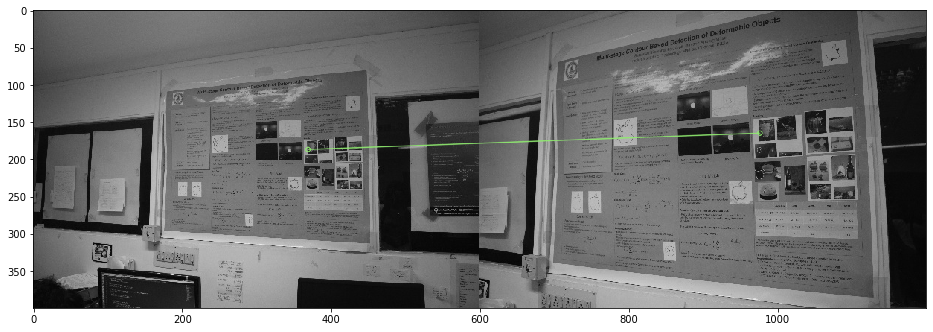

(<matplotlib.image.AxesImage at 0x7fed1f760d68>, None)

In [39]:
image1 = 'image'+str(imgs[0]+1)+'.jpg'
image2 = 'image'+str(imgs[1]+1)+'.jpg'
img1 = cv2.imread(image1,0)          # queryImage
img2 = cv2.imread(image2,0) # trainImage

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:1], None,flags=2)

plt.figure(figsize=(16,12))
plt.imshow(img3),plt.show()

In [40]:
pts1,pts2 = [],[]
for point in matches:
    pts1.append(kp1[point.queryIdx].pt)
    pts2.append(kp2[point.trainIdx].pt)
#     print(point.distance,point.queryIdx,point.trainIdx)
pts1 = np.asarray(pts1)
pts2 = np.asarray(pts2)
pts1[:,0] = pts1[:,0]*RESIZE_F/IMG_WIDTH
pts2[:,0] = pts2[:,0]*RESIZE_F/IMG_WIDTH
pts1[:,1] = pts1[:,1]*RESIZE_F/IMG_HEIGHT
pts2[:,1] = pts2[:,1]*RESIZE_F/IMG_HEIGHT
print(len(pts1))

268

In [41]:
iters = 5
trials = [100,1000,10000,100000]
for trial in trials:
    print('#'*20, trial, '#'*20)
    time_list = np.zeros(iters)
    matches = np.zeros_like(time_list)
    f_best = np.empty((3,3))
    n_matches = 0
    for i in range(iters):
        print('-'*50)
        f,time_,match,set_of_inliers,_ = ransac(pts1,pts2,N=trial,normalized=True,epsilon=0.05)
        time_list[i] = time_
        matches[i] = match
        if match > n_matches:
            f_best = f
            n_matches = match

    pts1_ = np.c_[pts1,np.ones(pts1.shape[0])]
    pts2_ = np.c_[pts2,np.ones(pts2.shape[0])]
    print(np.mean(time_list), np.std(time_list), np.mean(matches), np.std(matches))
    print(f_best, n_matches)

#################### 100 ####################
--------------------------------------------------
it:20/100,max_inliers_yet:189/268
it:40/100,max_inliers_yet:189/268
it:60/100,max_inliers_yet:252/268
it:80/100,max_inliers_yet:252/268
it:100/100,max_inliers_yet:252/268
(252, 9)
--------------------------------------------------
it:20/100,max_inliers_yet:214/268
it:40/100,max_inliers_yet:236/268
it:60/100,max_inliers_yet:236/268
it:80/100,max_inliers_yet:236/268
it:100/100,max_inliers_yet:249/268
(249, 9)
--------------------------------------------------
it:20/100,max_inliers_yet:224/268
it:40/100,max_inliers_yet:224/268
it:60/100,max_inliers_yet:224/268
it:80/100,max_inliers_yet:239/268
it:100/100,max_inliers_yet:239/268
(239, 9)
--------------------------------------------------
it:20/100,max_inliers_yet:213/268
it:40/100,max_inliers_yet:236/268
it:60/100,max_inliers_yet:236/268
it:80/100,max_inliers_yet:236/268
it:100/100,max_inliers_yet:236/268
(236, 9)
------------------------------